# CNN pretrained ResNet50 model 

Source of idea: https://www.ejcancer.com/article/S0959-8049(19)30349-1/fulltext#secsectitle0050 Chapter 2.2 Methods

#### Pretrained ResNet50 CNN:

* ResNet50 Model: ResNet50 is a deep convolutional neural network architecture originally designed for image classification tasks. It consists of 50 layers, including convolutional layers, batch normalization, and skip connections (residual connections), which allow it to effectively learn from very deep networks. The model is pretrained on a large dataset (typically ImageNet) to capture a wide range of features from images

* Transfer Learning: In transfer learning, we start with a pretrained model (ResNet50 in this case) and fine-tune it for a specific task. By doing this, we leverage the knowledge the model has gained from the original dataset and adapt it to a new task, such as classifying skin lesions

## Imports and loading Data

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from keras import backend as K
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import AUC, Precision, Recall
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.legacy import SGD
from tensorflow.keras.callbacks import ReduceLROnPlateau

from time import sleep 

import cv2
import sys
import os

sys.path.append("..")
from helperfunctions import modelhelper as mh
from helperfunctions import imagehelper as ih

SEED = 226
NUM_EPOCHS = 20

# File path variables
# please make sure to use the correct path to the meta data file

FILEPATH_JPGS = './../data/jpgs/'
FILEPATH_PROCESSED="./../data/processed/"
FILEPATH_OUTPUT = './../data/jpgs/'  # Replace with your folder path
FIELPATH_TESTOUTPUT= "./../data/testoutput/"

TARGET_LABEL="dx_tertiary"

IMAGE_SIZE = (224, 224)

BATCH_SIZE = 128

### Loading (augmented) metadata as test, train, validation from files

In [2]:
# Read the metadata file
train_df = pd.read_csv(FILEPATH_PROCESSED+"train_from_Metadata_processed.csv")
validation_df = pd.read_csv(FILEPATH_PROCESSED+"validation_from_Metadata_processed.csv")
test_df = pd.read_csv(FILEPATH_PROCESSED+"test_from_Metadata_processed.csv")

train_df.sample(15)

lesion_id                    image_id     dx    dx_type   age     sex   
2576  HAM_0001456            ISIC_0025835.jpg    mel      histo  75.0    male  \
852   HAM_0005610            ISIC_0027608.jpg    bkl   confocal  65.0  female   
4846  HAM_0002129  aug_6EbjF1ISIC_0025903.jpg     df  consensus  60.0    male   
2817  HAM_0003620            ISIC_0032511.jpg    mel      histo  70.0    male   
5216  HAM_0003290  aug_OfD688ISIC_0031358.jpg     df      histo  80.0    male   
114   HAM_0002522            ISIC_0028382.jpg     nv  follow_up  50.0  female   
2893  HAM_0007086            ISIC_0033267.jpg    mel      histo  65.0  female   
2821  HAM_0005627            ISIC_0033568.jpg    mel      histo  45.0    male   
1131  HAM_0002371            ISIC_0032271.jpg    bkl  consensus  50.0    male   
3545  HAM_0005268  aug_CUt1igISIC_0027825.jpg    bcc      histo  55.0    male   
2352  HAM_0000880            ISIC_0033089.jpg    mel      histo  60.0    male   
270   HAM_0003746            ISIC_0030437.jpg     nv  follow_up  25.0    male   
4289  HAM_0002390  aug_xJSyRpISIC_0029439.jpg   vasc  consensus  50.0    male   
4178  HAM_0000940  aug_QtakEsISIC_0033608.jpg   vasc      histo  35.0  female   
1755  HAM_0007349            ISIC_0032014.jpg  akiec      histo  60.0    male   

         localization        dataset        dx_binary     dx_tertiary   
2576  lower extremity   vidir_modern      skin_cancer       malignant  \
852              face   vidir_modern  not_skin_cancer  non-neoplastic   
4846          abdomen  vidir_molemax  not_skin_cancer  non-neoplastic   
2817            scalp   vidir_modern      skin_cancer       malignant   
5216  upper extremity      rosendahl  not_skin_cancer  non-neoplastic   
114           abdomen  vidir_molemax  not_skin_cancer          benign   
2893             back   vidir_modern      skin_cancer       malignant   
2821             back   vidir_modern      skin_cancer       malignant   
1131            chest  vidir_molemax  not_skin_cancer  non-neoplastic   
3545            chest      rosendahl      skin_cancer       malignant   
2352             face   vidir_modern      skin_cancer       malignant   
270             trunk  vidir_molemax  not_skin_cancer          benign   
4289          abdomen  vidir_molemax  not_skin_cancer  non-neoplastic   
4178  lower extremity   vidir_modern  not_skin_cancer  non-neoplastic   
1755             back      rosendahl      skin_cancer       malignant   

                                     image_path  
2576            ./../data/jpgs/ISIC_0025835.jpg  
852             ./../data/jpgs/ISIC_0027608.jpg  
4846  ./../data/jpgs/aug_6EbjF1ISIC_0025903.jpg  
2817            ./../data/jpgs/ISIC_0032511.jpg  
5216  ./../data/jpgs/aug_OfD688ISIC_0031358.jpg  
114             ./../data/jpgs/ISIC_0028382.jpg  
2893            ./../data/jpgs/ISIC_0033267.jpg  
2821            ./../data/jpgs/ISIC_0033568.jpg  
1131            ./../data/jpgs/ISIC_0032271.jpg  
3545  ./../data/jpgs/aug_CUt1igISIC_0027825.jpg  
2352            ./../data/jpgs/ISIC_0033089.jpg  
270             ./../data/jpgs/ISIC_0030437.jpg  
4289  ./../data/jpgs/aug_xJSyRpISIC_0029439.jpg  
4178  ./../data/jpgs/aug_QtakEsISIC_0033608.jpg  
1755            ./../data/jpgs/ISIC_0032014.jpg

## Setting up the image data generator for training and validation

#### Function for custom preprocessing of the images

In [3]:
def custom_preprocessing(np_image, image_size, show_image=False):
    # print the image
    # print("From custom_preprocessing: Image + shape before preprocessing:", np_image.shape)
    np_image = np_image.astype(np.uint8)
    
    #print(np_image)
    if show_image:
        plt.imshow(np_image.astype(np.uint8))
        plt.show()

    # rescale 
    np_image = np_image / 255.0

    # Using the image helper functions
    np_image = ih.center_crop_image(np_image) # Crop image to square format
    
    if show_image:
        print("From custom_preprocessing: Image after center crop:", np_image.shape)
        plt.imshow(np_image)
        plt.show()

    np_image = ih.resize_as_preprocess(np_image, image_size) # resize the image

    if show_image:
        print("From custom_preprocessing: Image after after resizing:", np_image.shape)
        plt.imshow(np_image)
        plt.show()

    return np_image

In [4]:
"""# Augmentation parameters for Randomsearch
horizontal_flip = hp.Boolean("horizontal_flip")
vertical_flip = hp.Boolean("vertical_flip")
zoom_range = hp.Float("zoom_range", min_value=0.0, max_value=0.5)
width_shift_range = hp.Float("width_shift_range", min_value=0.0, max_value=0.5)
height_shift_range = hp.Float("height_shift_range", min_value=0.0, max_value=0.5)
rotation_range = hp.Int("rotation_range", min_value=0, max_value=180)
shear_range = hp.Float("shear_range", min_value=0.0, max_value=0.5)
"""

# Setting up the Image Data Generator for the train and validation data set
datagen_train = ImageDataGenerator(
    preprocessing_function=lambda x: custom_preprocessing(x, IMAGE_SIZE), # Apply the custom preprocessing function 
    horizontal_flip=True,        # Randomly flip images horizontally
    vertical_flip=True,          # Randomly flip images vertically
    zoom_range=0.2,              # Randomly zoom in and out by up to 20%
    width_shift_range=0.2,       # Randomly shift images horizontally by up to 20%
    height_shift_range=0.2,      # Randomly shift images vertically by up to 20%
    rotation_range=30,           # Randomly rotate images by up to 30 degrees
    shear_range=0.2,             # Shear intensity (shear angle in radians)
    fill_mode='nearest'          # Strategy for filling in newly created pixels after transformations
)

datagen_validation = ImageDataGenerator(
    preprocessing_function=lambda x: custom_preprocessing(x, IMAGE_SIZE)
)

train_data_generator = datagen_train.flow_from_dataframe(
    dataframe=train_df,
    color_mode='rgb',
    directory=FILEPATH_JPGS,
    target_size=IMAGE_SIZE,
    x_col="image_id",
    y_col=TARGET_LABEL,
    class_mode="categorical",
    batch_size=BATCH_SIZE,
)

validation_generator = datagen_validation.flow_from_dataframe(
    dataframe=validation_df,
    directory=FILEPATH_JPGS,
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    x_col="image_id",
    y_col=TARGET_LABEL,
    class_mode="categorical",
    batch_size=BATCH_SIZE
)

Found 5254 validated image filenames belonging to 3 classes.
Found 1001 validated image filenames belonging to 3 classes.


In [5]:
def show_image_samples(gen):
    t_dict = gen.class_indices
    classes = list(t_dict.keys())    
    images, labels = next(gen)  
    plt.figure(figsize=(25, 25))
    length = len(labels)
    if length < 25:  
        r = length
    else:
        r = 25
    for i in range(r):        
        plt.subplot(5, 5, i + 1)
        image = images[i]  
        plt.imshow(image)
        index = np.argmax(labels[i])
        class_name = classes[index]
        plt.title(class_name, color='blue', fontsize=18)
        plt.axis('off')
    plt.show()

In [6]:
images, labels = next(train_data_generator)
print(images.min(), images.max(), images.dtype)

0.0 1.0 float32


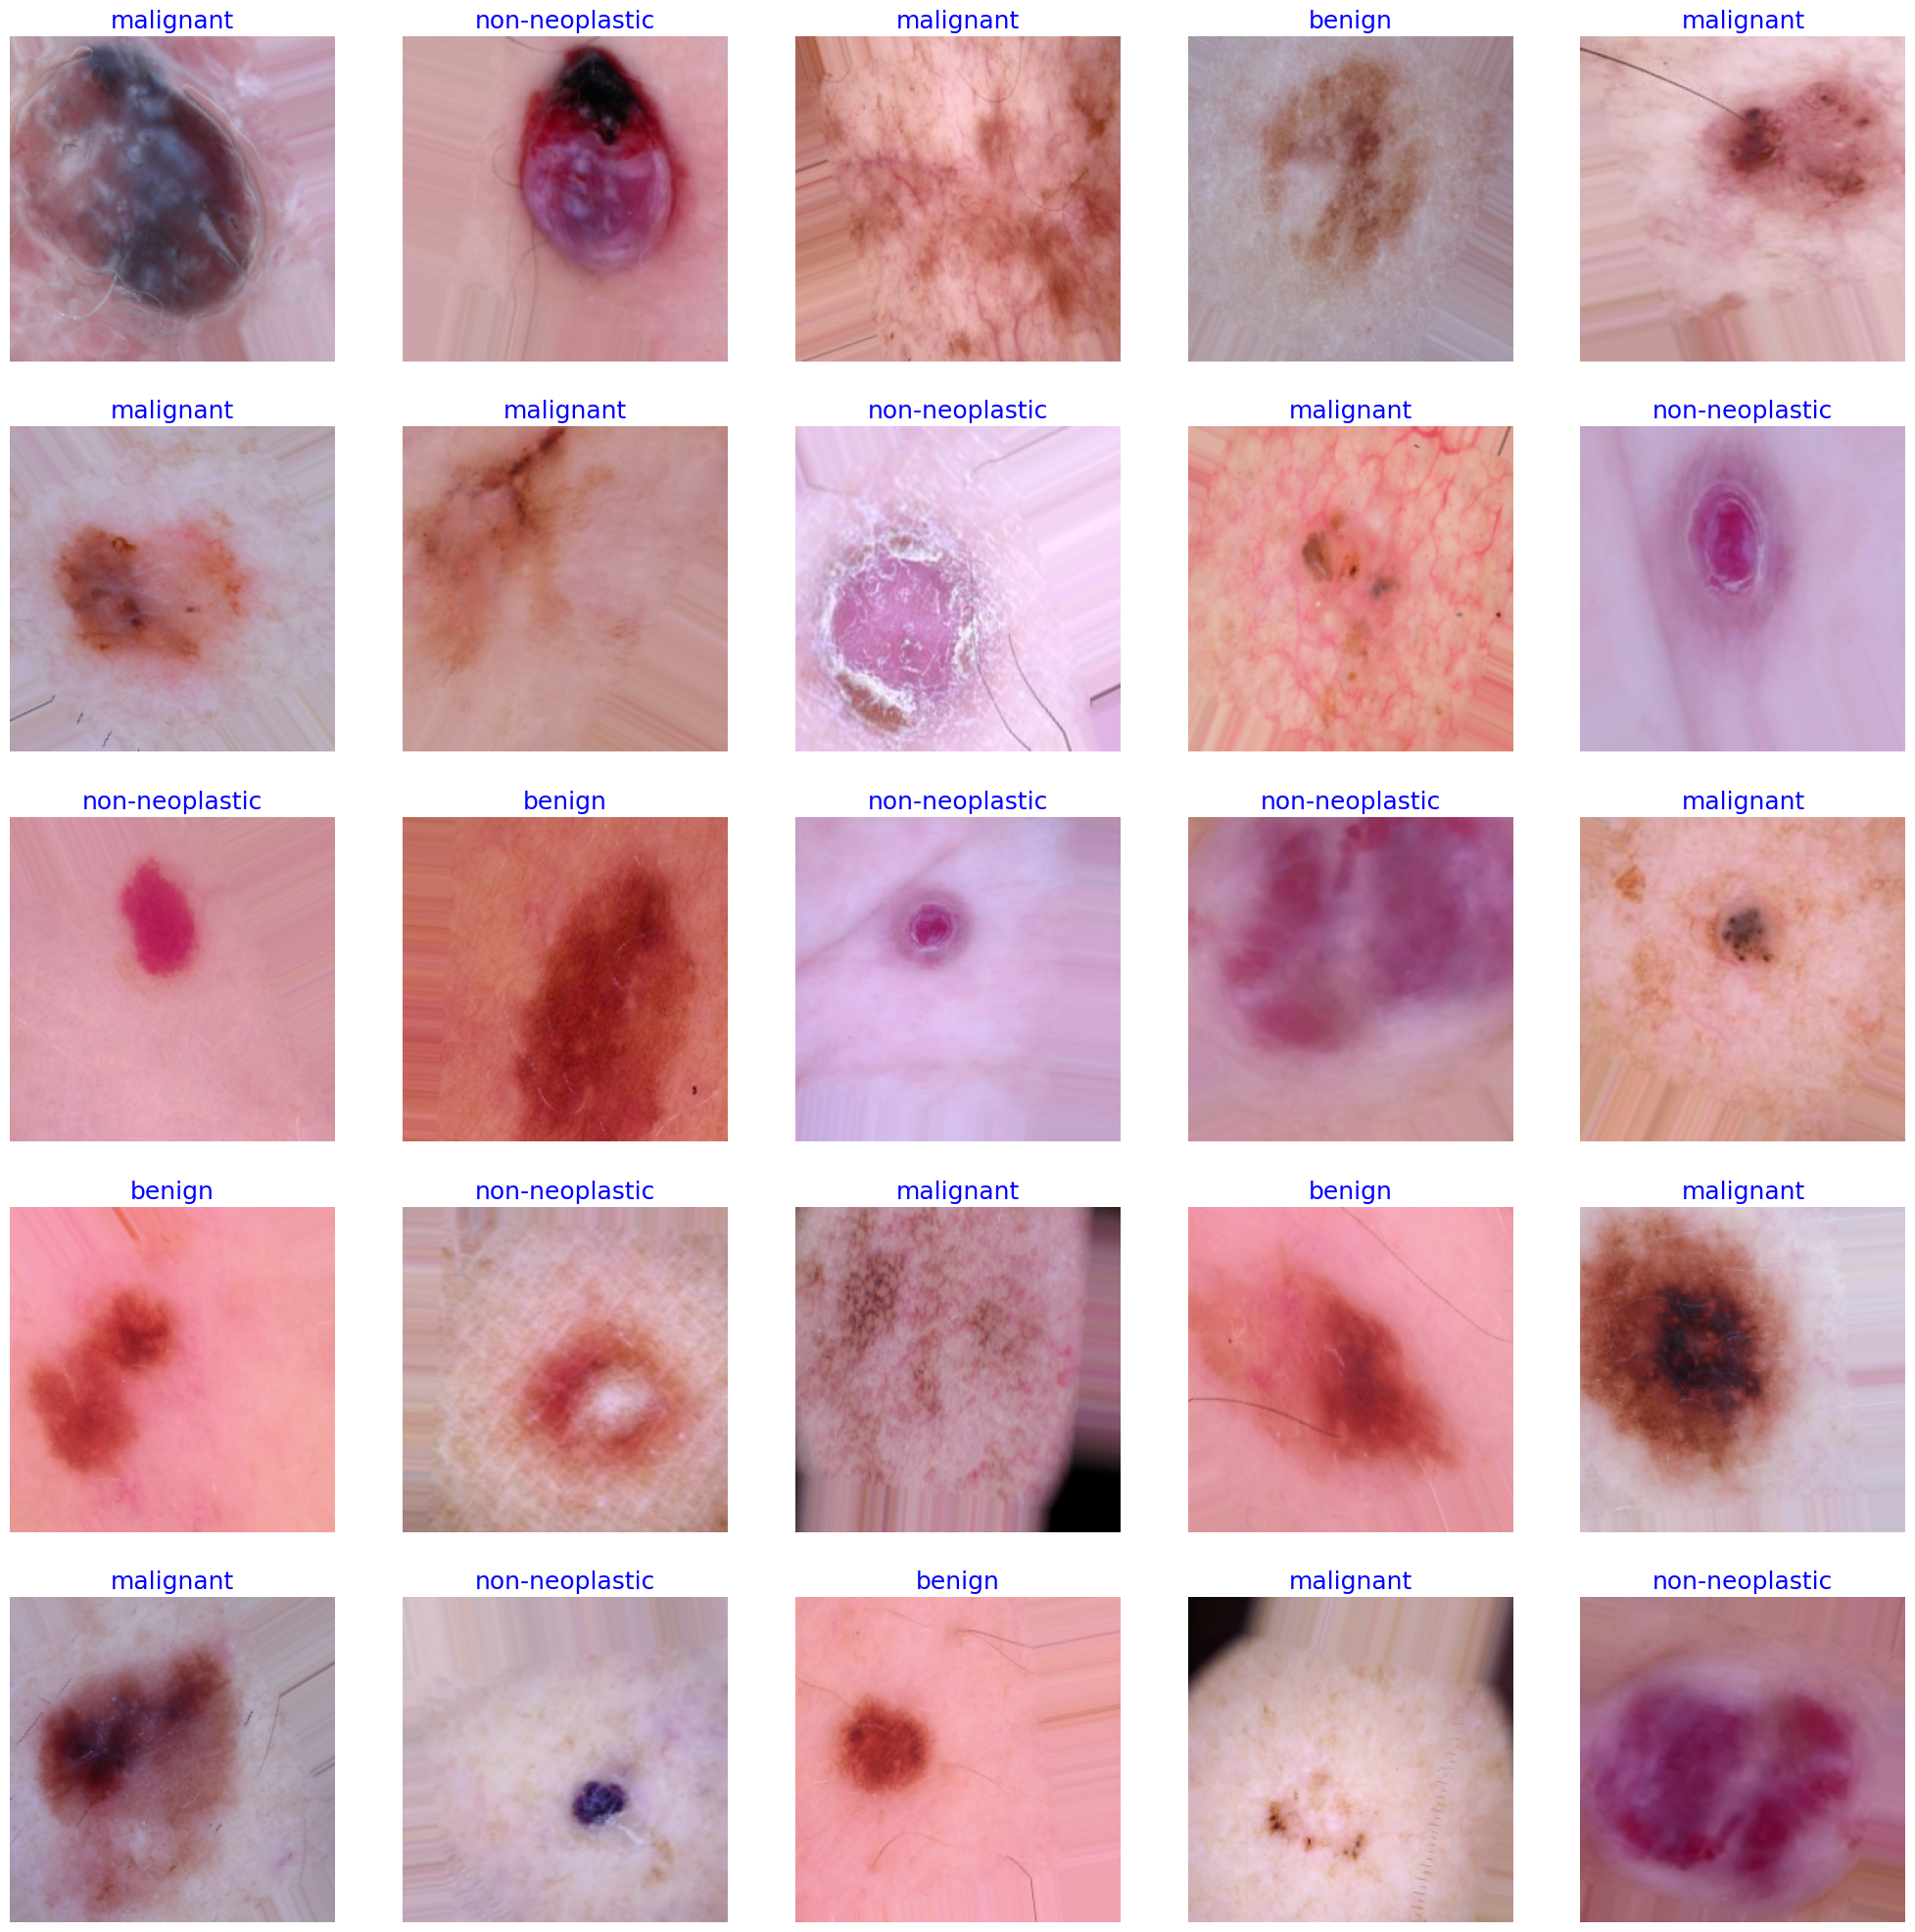

In [7]:
show_image_samples(train_data_generator)

## ResNet50


#### F1 score metric function for model compilation

In [8]:
def f1_score(y_true, y_pred):
    # Calculate precision
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())

    # Calculate recall
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())

    # Calculate F1 score
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

#### focal loss function for model compilation (not yet in use)

In [9]:
def focal_loss(alpha=0.25, gamma=2.0):
    def focal_loss_fixed(y_true, y_pred):
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1 + K.epsilon())) \
               -K.sum((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0 + K.epsilon()))
    return focal_loss_fixed

#### Model architecture

In [11]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Conv2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers.legacy import Adam as LegacyAdam
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
from keras_tuner.tuners import RandomSearch
from keras_tuner.engine import hyperparameters
import math
import tensorflow as tf
from sklearn.utils import class_weight
import os

# Define a function to build the model
def build_model(hp):

    # Create a base ResNet50 model
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    
    # Define the number of classes
    num_classes = len(train_data_generator.class_indices)
    
    # Freeze layers in the base model
    for layer in base_model.layers:
        layer.trainable = True
    
    # Optimizer choice
    optimizer_choice = hp.Choice("optimizer", values=["adam", "sgd"])

    if optimizer_choice == "adam":
        optimizer = LegacyAdam(learning_rate=hp.Choice("adam_learning_rate", values=[1e-2, 1e-3, 1e-4]))
    elif optimizer_choice == "sgd":
        optimizer = SGD(learning_rate=hp.Choice("sgd_learning_rate", values=[1e-2, 1e-3, 1e-4]))

    # Loss function choice
    loss_function_choice = hp.Choice("loss_function", values=["categorical_crossentropy", "focal_loss"])

    if loss_function_choice == "categorical_crossentropy":
        loss = "categorical_crossentropy"
    elif loss_function_choice == "focal_loss":
        alpha = hp.Float("focal_loss_alpha", min_value=0.0, max_value=1.0)
        gamma = hp.Float("focal_loss_gamma", min_value=0.0, max_value=5.0)
        loss = focal_loss(alpha=alpha, gamma=gamma)


    # Add custom layers for classification
    x = base_model.output
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = GlobalAveragePooling2D()(x)
    x = Dense(hp.Int("dense_units", min_value=32, max_value=256, step=32), activation='relu')(x)
    x = Dense(num_classes, activation='softmax')(x)

    # Create the final model
    model = Model(inputs=base_model.input, outputs=x)

   # Compile the model
    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy', f1_score]
    )

    return model  

### Callback functions

#### Learning rate scheduler for model compilation

In [12]:
#defining a learning rate scheduler
import math
from tensorflow.keras.callbacks import LearningRateScheduler

# Define a learning rate schedule function
def lr_schedule(epoch):
    """
    Learning rate schedule function.
    
    Args:
        epoch (int): The current epoch number.
        
    Returns:
        float: The learning rate for the current epoch.
    """
    initial_lr = 0.0001  # Initial learning rate
    drop = 0.5  # Learning rate drop factor
    epochs_drop = 5  # Number of epochs after which learning rate will drop

    # Calculate the learning rate for the current epoch
    lr = initial_lr * math.pow(drop, math.floor((1 + epoch) / epochs_drop))
    return lr

# Create a LearningRateScheduler callback
lr_scheduler = LearningRateScheduler(lr_schedule)

#### Class weights 

In [13]:
from sklearn.utils import class_weight
import numpy as np
class_weights = class_weight.compute_class_weight('balanced',
                                                 classes=np.unique(train_df[TARGET_LABEL]),
                                                    y=train_df[TARGET_LABEL])
class_weights = dict(enumerate(class_weights))
class_weights

{0: 2.335111111111111, 1: 0.7776791000592066, 2: 0.7776791000592066}

#### Early stopping

In [14]:
from tensorflow.keras.callbacks import EarlyStopping

# Define the early stopping callback
early_stopping = EarlyStopping(
    monitor='val_f1_score',  # Metric to monitor for early stopping
    patience=5,         # Number of epochs with no improvement to wait before stopping
    restore_best_weights=True  # Restore the model weights to the best epoch
    # set range in loss function
)

#### Random Search tuner for hyhperparameter tuning

In [15]:
 # Create a RandomSearch tuner
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,  # Number of different hyperparameter combinations to try
    directory='random_search',  # Directory to save results
    project_name='cnn_hyperparameter_tuning'  # Name of the project
)

# Search for the best hyperparameters
tuner.search(
    train_data_generator,
    epochs=NUM_EPOCHS,
    validation_data=validation_generator,
    callbacks=[lr_scheduler, early_stopping],
    class_weight=class_weights,  # Optional class weights for loss calculation
    verbose=1
)

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Get the best model directly from the tuner
best_models = tuner.get_best_models(num_models=1)

# Build the final model using the best model
final_model = best_models[0]


Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
adam              |adam              |optimizer
0.001             |0.001             |adam_learning_rate
categorical_cro...|categorical_cro...|loss_function
224               |224               |dense_units

Epoch 1/20
 3/42 [=>............................] - ETA: 18:29 - loss: 1.1265 - accuracy: 0.4844 - f1_score: 0.4490

## Model Training

In [ ]:
# Train the model
history = final_model.fit(
    train_data_generator,  # Training data generator
    epochs=NUM_EPOCHS,  # Number of training epochs
    verbose=1,  # Verbosity level during training (0, 1, or 2)
    batch_size=BATCH_SIZE,  # Batch size for training
    callbacks=[lr_scheduler, early_stopping],  # List of callbacks to apply during training
    validation_split=0.0,  # Fraction of the training data to use as validation data (0.0 means no split)
    validation_data=validation_generator,  # Validation data generator
    shuffle=True,  # Shuffle the training data before each epoch
    sample_weight=None,  # Optional sample weights for training data
    class_weight=class_weights,  # Optional class weights for loss calculation
    initial_epoch=0,  # Initial training epoch (useful for resuming training)
    steps_per_epoch=None,  # Number of steps per epoch (default is len(x_train) // batch_size)
    validation_steps=None,  # Number of steps for validation (default is len(x_val) // batch_size)
    validation_batch_size=None,  # Batch size for validation (default is batch_size)
    validation_freq=1,  # Frequency to validate the model on the validation set
    max_queue_size=10,  # Maximum size of the generator queue
    workers=-1,  # Maximum number of processes to generate data in parallel (-1 means all CPUs)
    use_multiprocessing=False  # Use multiprocessing for data generation (True or False)
)

Epoch 1/20
165/165 [==============================] - 1057s 6s/step - loss: 0.6654 - accuracy: 0.6938 - f1_score: 0.6755 - val_loss: 1.2806 - val_accuracy: 0.1359 - val_f1_score: 0.1378 - lr: 1.0000e-04
Epoch 2/20
165/165 [==============================] - 1394s 8s/step - loss: 0.4566 - accuracy: 0.7965 - f1_score: 0.7902 - val_loss: 1.0858 - val_accuracy: 0.2338 - val_f1_score: 0.0306 - lr: 1.0000e-04
Epoch 3/20
165/165 [==============================] - 1405s 9s/step - loss: 0.3724 - accuracy: 0.8386 - f1_score: 0.8346 - val_loss: 1.6497 - val_accuracy: 0.1439 - val_f1_score: 0.1432 - lr: 1.0000e-04
Epoch 4/20
165/165 [==============================] - 1391s 8s/step - loss: 0.3576 - accuracy: 0.8439 - f1_score: 0.8424 - val_loss: 1.7819 - val_accuracy: 0.2817 - val_f1_score: 0.2629 - lr: 1.0000e-04
Epoch 5/20
165/165 [==============================] - 1464s 9s/step - loss: 0.2652 - accuracy: 0.8816 - f1_score: 0.8816 - val_loss: 1.8298 - val_accuracy: 0.5085 - val_f1_score: 0.5063 - 

## Plotting accuracy and loss of train and validation set

#### Plotting Accuracy  of train and validation set

(0.0, 1.0)

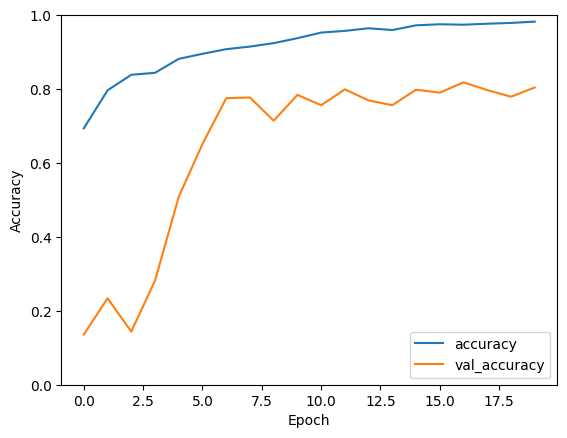

In [ ]:
# plotting accuracy of train and validation
import matplotlib.pyplot as plt
mh.model_plot_accuracy(history)
plt.ylim(0,1)

#### F1 Score of train and validation set

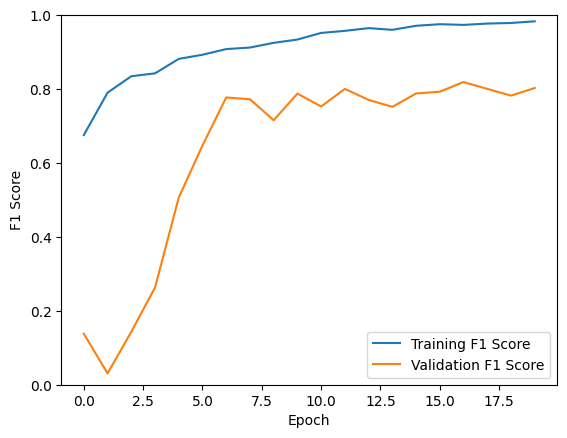

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have a variable named 'history' containing the training history
# (e.g., history = model.fit(...) where model is your Keras model)
# You can access the loss values from 'history.history'

# Plot the loss functions
plt.plot(history.history['f1_score'], label='Training F1 Score')
plt.plot(history.history['val_f1_score'], label='Validation F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.ylim([0, 1])  # Set the y-axis limits as needed
plt.legend(loc='lower right')  # You can adjust the legend position
plt.show()  # Show the plot

#### Plotting Loss of train and validation set

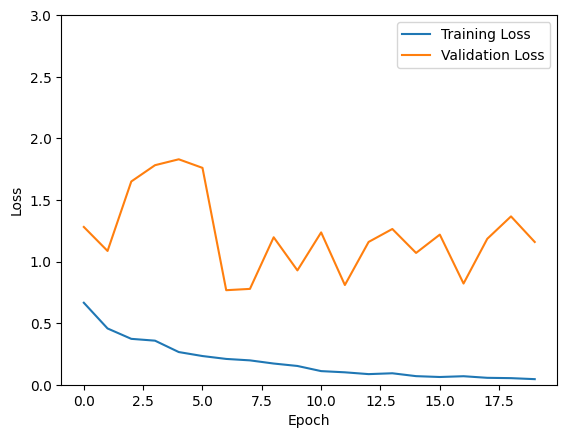

In [ ]:
import matplotlib.pyplot as plt

# Plot the loss functions
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 3])  # Set the y-axis limits as needed
plt.legend(loc='upper right')  # You can adjust the legend position
plt.show()  # Show the plot


## Evaluating the model on the test set

 > Evaluating model Resnet50_tertiary_earlystopping_valaccuracy_augmentation_in_train_data_generator:
 > Loading test images...
 > Test images loaded.


 > Converting labels to one hot format...
 > Getting model predictions...
32/32 [==============================] - 47s 1s/step
 > Model predictions obtained.
 > Macro AUC: 0.9467318106348364
 > Micro AUC: 0.9489787889291277


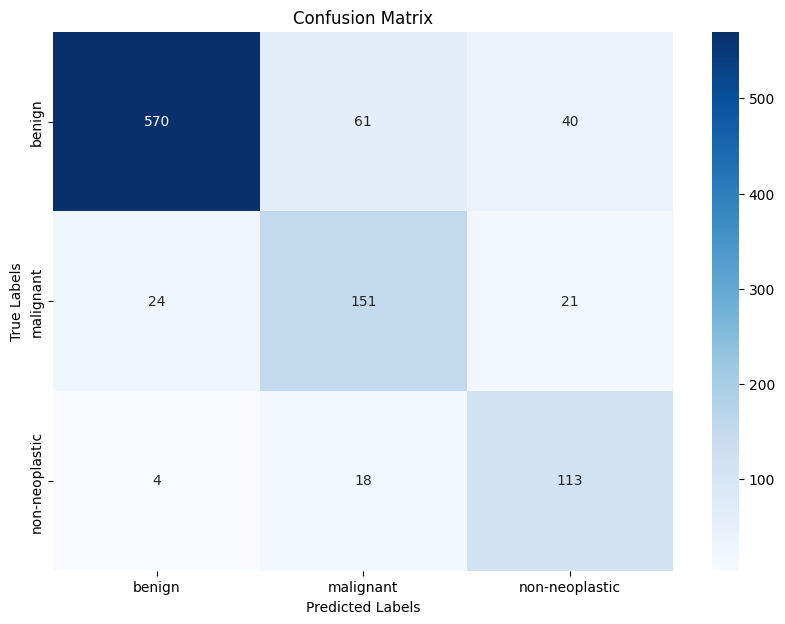



 > Computing classification report...
              precision    recall  f1-score   support

           0       0.95      0.85      0.90       671
           1       0.66      0.77      0.71       196
           2       0.65      0.84      0.73       135

    accuracy                           0.83      1002
   macro avg       0.75      0.82      0.78      1002
weighted avg       0.85      0.83      0.84      1002

 > Evaluating model on test set...
32/32 [==============================] - 47s 1s/step - loss: 0.8830 - accuracy: 0.8323 - f1_score: 0.8276
loss: 0.8829754590988159
accuracy: 0.832335352897644
f1_score: 0.8276072144508362
 > Done.


([{'loss': 0.8829754590988159},
  {'accuracy': 0.832335352897644},
  {'f1_score': 0.8276072144508362}],
 array([[570,  61,  40],
        [ 24, 151,  21],
        [  4,  18, 113]]),
 (0.9489787889291277, 0.9467318106348364))

In [ ]:
mh.model_accuracy_on_test(model, test_df, TARGET_LABEL, IMAGE_SIZE)

## Saving the model

In [ ]:
# Save the final model
final_model.save('best_hyperparameters_first_try.h5')

In [ ]:
from datetime import datetime
timestamp = datetime.now()
model_path = f"../models/model_{timestamp}.h5"
model.save(model_path)

/Users/janicepelzer/Documents/neuefische/capstone-healthy-skin/.venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
